# Homework 2 (Linear models, Optimization)

In this homework you will implement a simple linear classifier using numpy and your brain.

## Two-dimensional classification

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:, 0:2] = X
    X_[:, 2:4] = X ** 2
    X_[:, 4] = X[:, 0] * X[:, 1]
    X_[:, 5] = 1
    return X_


def predicted(X, w):
    return expand(X).dot(w)


def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    return np.sign(predicted(X, w))

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$

$$ {\partial{l} \over \partial{w}} = \left\{\begin{matrix}
0 & y_iw*x\geq 1\\ 
-y_ix & y_iw*x < 1 
\end{matrix}\right.$$




In [5]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    margins = np.maximum(0, 1 - y * predicted(X, w))
    return margins.mean(axis=0)


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_ = expand(X)
    v = y * X_.dot(w)
    zeros = np.where(v < 1, 1, 0)
    return np.sum((-(y*X_.T)*zeros).T, axis=0)

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

In [74]:
def _seek_learning_rate(_decent_func, iter=20, *args, **kwargs):
    best_learning_rate = 0
    loss = []
    best_loss = 1
    for learning_rate in np.arange(0, 1, 0.01):
        iter_losses = [
            _decent_func(learning_rate, *args, **kwargs)
            for _ in xrange(1, iter)]
        _losses = {l[-1]: l for l in iter_losses}
        best_iter_loss = min(_losses.iterkeys())
        if best_iter_loss < best_loss:
            loss = _losses[best_iter_loss]
            best_loss = best_iter_loss
            best_learning_rate = learning_rate
    return best_learning_rate, best_loss, loss


def _seek_momentum_and_learning_rate(_decent_func, *args, **kwargs):
    best_momentum = 0
    best_loss = 1
    loss = []
    best_learning_rate = 0
    
    for momentum in np.arange(0.7, 1, 0.01):
        _best_learning_rate, best_iter_loss, iter_loss = _seek_learning_rate(
            _decent_func, iter=3, mu=momentum, *args, **kwargs)
        if best_iter_loss < best_loss:
            best_loss = best_iter_loss
            loss = iter_loss
            best_learning_rate = _best_learning_rate
            best_momentum = momentum
    return best_momentum, best_learning_rate, best_loss, loss

0.26
0.168480540488


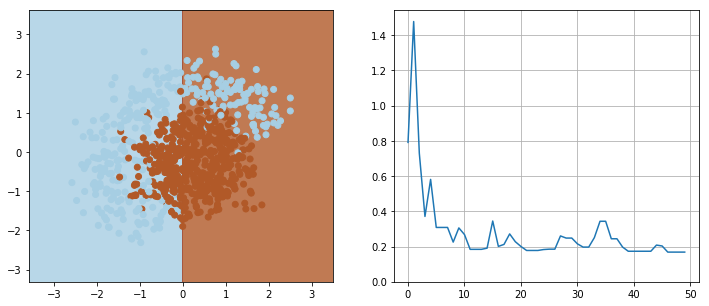

In [56]:
def _batch_descent(alpha):
    w = np.array([1, 0, 0, 0, 0, 0])
    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        v = - alpha * compute_grad(X[ind, :], y[ind], w)
        w = w + v
    return loss
best_learning_rate, best_loss, loss = _seek_learning_rate(_batch_descent)
print best_learning_rate
print best_loss
plt.figure(figsize=(12, 5))
visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

best loss: 0.166247037408, best momentum: 0.8, best learning rate: 0.03


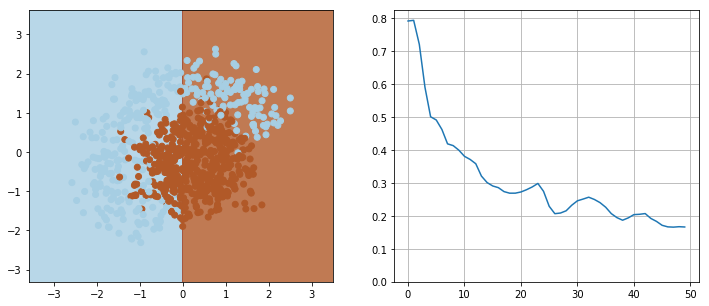

In [68]:
def _momentum_descent(alpha, mu):
    v = np.zeros(6, dtype='float64')
    w = np.array([1, 0, 0, 0, 0, 0], dtype='float64')
    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        v = mu * v - alpha * compute_grad(X[ind, :], y[ind], w)
        w = w + v
    return loss

best_momentum, best_learning_rate, best_loss, loss = _seek_momentum_and_learning_rate(
    _momentum_descent)

plt.figure(figsize=(12, 5))
print 'best loss: {}, ' \
      'best momentum: {}, ' \
      'best learning rate: {}'.format(
        best_loss, best_momentum, best_learning_rate)
visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

best loss: 0.168139161335, best momentum: 0.93, best learning rate: 0.01


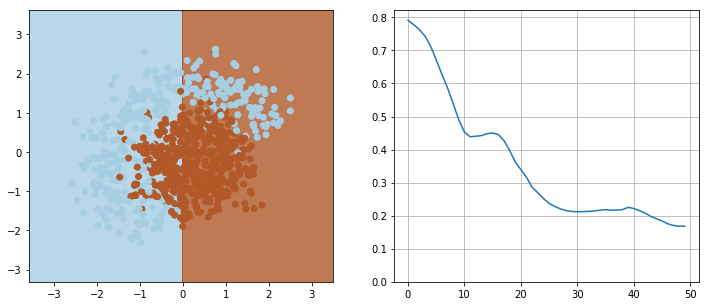

In [69]:
def _nesterov_descent(alpha, mu):
    v = np.zeros(6, dtype='float64')
    w = np.array([1, 0, 0, 0, 0, 0], dtype='float64')
    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        grad = compute_grad(X[ind, :], y[ind], w+mu * v)
        v = mu * v - alpha * grad
        w = w + v
    return loss


best_momentum, best_learning_rate, best_loss, loss = _seek_momentum_and_learning_rate(
    _nesterov_descent)

plt.figure(figsize=(12, 5))
print 'best loss: {}, ' \
      'best momentum: {}, ' \
      'best learning rate: {}'.format(
        best_loss, best_momentum, best_learning_rate)
visualize(X, y, w, loss, n_iter)

Finally, try Adam algorithm. You can start with beta = 0.9 and mu = 0.999

best loss: 0.187437364983, best learning rate: 0.24, best mu: 0.98


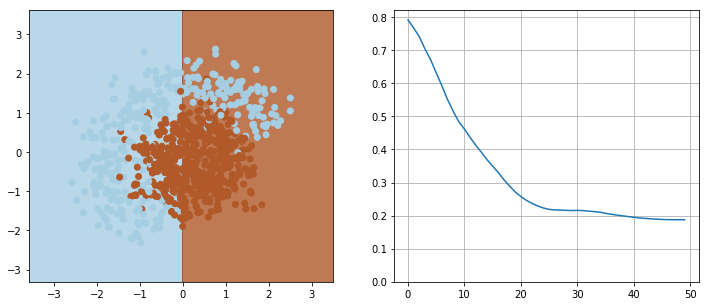

In [78]:
n_iter = 50
w = np.array([1, 0, 0, 0, 0, 0], dtype='float64')


def _adam_descent(alpha, mu, w, beta, eps=1e-8):
    v = np.zeros(6, dtype='float64')
    g = np.zeros(6, dtype='float64')
    batch_size = 4
    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        grad = compute_grad(X[ind, :], y[ind], w + mu * v)
        v = beta * v + (1 - beta) * grad
        g = mu * g + (1 - mu) * grad * grad
        frac = (1 - beta) / ((1 - mu) * np.sqrt(g + eps))
        w = w - alpha * frac * v
    return loss


best_mu, best_lr, best_loss, loss = _seek_momentum_and_learning_rate(
    _adam_descent,beta=0.98, w=w)

# for beta in np.arange(0.90, 1, 0.01):
#     best_iter_mu, best_iter_lr, best_iter_loss, iter_loss = _seek_momentum_and_learning_rate(
#         _adam_descent, beta=beta, w=w)
#     if best_iter_loss < best_loss:
#         best_loss = best_iter_loss
#         best_lr = best_iter_lr
#         best_beta = beta
#         loss = iter_loss
        
plt.figure(figsize=(12, 5))
print 'best loss: {}, ' \
      'best learning rate: {}, '\
      'best mu: {}'.format(
        best_loss, best_lr, best_mu)

visualize(X, y, w, loss, n_iter)
plt.clf()

Which optimization method do you consider the best? Type your answer in the cell below

In [ ]:
понятно, что выбор метода зависит от данных, насколько они разряжены и т.д. На учебном примере лучший результат по разумному перебору параметров
дал моментный спуск (потеря 0.166). Если посмотреть на выводы например, http://sebastianruder.com/optimizing-gradient-descent/index.html#visualizationofalgorithms,  
я бы все таки выбрала Adam